In [3]:
from numba import cuda

# clear GPU cache
cuda.select_device(0)
cuda.close()

In [7]:
import keras as ks
import numpy as np

# import model from model.h5
model = ks.models.load_model('atlas.h5')
model2 = ks.models.load_model('atlas2.h5')
model3 = ks.models.load_model('atlas3.h5')
model4 = ks.models.load_model('atlas4.h5')


print(model.summary())
print(model2.summary())
print(model3.summary())
print(model4.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 238, 318, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 117, 157, 24)      19224     
                                                                 
 conv2d_2 (Conv2D)           (None, 57, 77, 36)        21636     
                                                                 
 conv2d_3 (Conv2D)           (None, 27, 37, 48)        43248     
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 35, 64)        27712     
                                                                 
 conv2d_5 (Conv2D)           (None, 23, 33, 64)        36928     
                                                                 
 dropout (Dropout)           (None, 23, 33, 64)        0

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image


# get data from Collector/frames/*.jpg

frames = []
frameNumber = 0
while True:
    try:
        # look for the next frame in the frames folder stored as jpg
        image = Image.open('../Collector/dataset/' + str(frameNumber) + '.jpg')
        frameNumber += 1
        # convert to numpy array
        image = np.array(image)
        # add the image to the end of the frames array
        frames = frames + [image]

    except Exception as e:
        break

In [2]:
# load in the steering data from the csv file
steering = []
with open('../Collector/dataset/data.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        steering = steering + [float(row[0])]

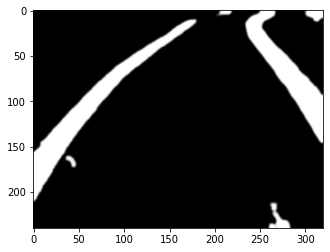

In [3]:
# preprocess the data to be used in the neural network
import cv2 as cv
import PIL
from keras.preprocessing.image import img_to_array

processedFrames = []

#loop through the images and filter green pixels
for i in range(len(frames)):
    blur = cv.GaussianBlur(frames[i], (35, 35), 0)
    # isolate green channel
    hsv = cv.cvtColor(blur, cv.COLOR_BGR2HSV)
    # isolate green channel
    mask = cv.inRange(hsv, (10, 0, 40), (80, 255, 240))
    mask = cv.GaussianBlur(mask, (5, 5), 0)
    mask = cv.erode(mask, None, iterations=2)
    mask = cv.dilate(mask, None, iterations=2)
    mask = cv.GaussianBlur(mask, (5, 5), 0)
    # display the green channel
    # reduce the size of the image by a factor of 2
    # convert to array
    array = np.array(mask)
    # resize the array by 50%
    resized = cv.resize(array, (0, 0), fx=0.5, fy=0.5)
    # add the image to the end of the processedFrames array
    processedFrames.append(resized)
    
    

plt.imshow(processedFrames[0], cmap='gray')

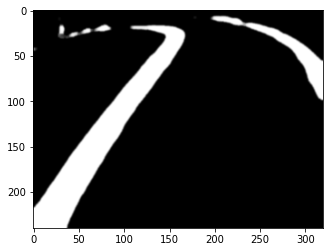

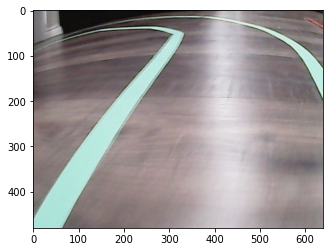

In [10]:
plt.imshow(processedFrames[1700], cmap='gray')
plt.show()
plt.imshow(frames[1700], cmap='gray')

In [4]:
processedFrames = np.array(processedFrames)
print(len(processedFrames))

# shuffle the data the same 
from sklearn.utils import shuffle
processedFrames, steering = shuffle(processedFrames, steering, random_state=0)

12284


Creating model
compiling model...
fitting model...
Epoch 1/10
85/85 [==============================] - 186s 2s/step - loss: 1698.4663 - val_loss: 926.0780
Epoch 2/10
85/85 [==============================] - 190s 2s/step - loss: 825.6516 - val_loss: 333.7851
Epoch 3/10
85/85 [==============================] - 189s 2s/step - loss: 635.9456 - val_loss: 309.3452
Epoch 4/10
85/85 [==============================] - 190s 2s/step - loss: 399.2637 - val_loss: 1315.5701
Epoch 5/10
85/85 [==============================] - 190s 2s/step - loss: 428.6534 - val_loss: 1275.4554
Epoch 6/10
85/85 [==============================] - 190s 2s/step - loss: 342.0636 - val_loss: 200.9534
Epoch 7/10
85/85 [==============================] - 190s 2s/step - loss: 215.5840 - val_loss: 246.9286
Epoch 8/10
85/85 [==============================] - 189s 2s/step - loss: 251.5136 - val_loss: 138.8347
Epoch 9/10
85/85 [==============================] - 190s 2s/step - loss: 286.0666 - val_loss: 143.6572
Epoch 10/10
85/85 [

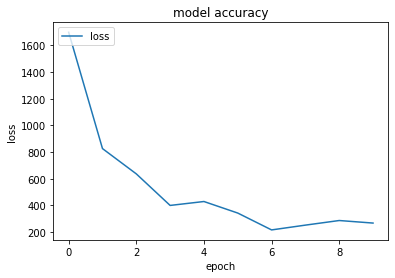

-1431.5095825195312
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 231, 311, 32)      3232      
                                                                 
 activation (Activation)     (None, 231, 311, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 77, 103, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 73, 99, 32)        25632     
                                                                 
 activation_1 (Activation)   (None, 73, 99, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 33, 32)       0         
 2D)                                

In [16]:
# create a model with 3 convolutional layers and 1 fully connected layer
# that outputs a steering angle when given an image and steering data as input
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
from keras import backend as K
import time

K.clear_session()

# use cpu instead of gpu
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

print("Creating model")
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(240, 320, 1)))
model.add(Conv2D(24, (5, 5) , strides=(2,2) , activation='relu'))
model.add(Conv2D(36, (5, 5) , strides=(2,2) , activation='relu'))
model.add(Conv2D(48, (5, 5) , strides=(2,2) , activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())

model.add(Dense(1000))
model.add(Dense(500))
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(5))
model.add(Dense(1))


print('compiling model...')
# compile the model
model.compile(optimizer='adam', loss='mse')

print('fitting model...')
# train the model
model.fit(processedFrames, np.array(steering) , epochs=100, verbose=1, validation_split=0.3, shuffle=True, batch_size=64)
# graph the loss and accuracy
plt.plot(model.history.history['loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'], loc='upper left')
plt.show()

# print difference between the start and end loss
print(model.history.history['loss'][-1] - model.history.history['loss'][0])

#show what each layer looks like
model.summary()

#clear session
print('clearing session')
K.clear_session()



In [8]:
model = ks.models.load_model('atlas4.h5')

In [17]:
# print rsquared and mean squared error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('r squared: ' + str(r2_score(steering, model.predict(processedFrames))))
print('mean squared error: ' + str(mean_squared_error(steering, model.predict(processedFrames))))

r squared: -1.1323250206021753
mean squared error: 883.9938469588758


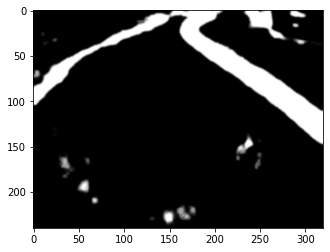

[[56.41972]]


In [16]:
frameNumber = 9
# grab the first image from the frames array
image = processedFrames[frameNumber]




# show the image and steering data
plt.imshow(image, cmap='gray')
plt.show()

# predict the steering angle for the first image
prediction = model.predict(image.reshape(1, 240, 320, 1))
print(prediction)

In [17]:
#save the model
model.save('atlas3.h5')

In [136]:
import tensorflow as tf 

if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:

   print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [7]:
from numba import cuda
# clear session
print('clearing session')
cuda.select_device(0)
cuda.close()


clearing session
